# Imports

In [3]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Data Preprocessing

In [11]:
df=pd.read_csv("spotify_history.csv")
arrShuffle=df["shuffle"]
arrReason_End=df["reason_end"]
arrMs_Played=df["ms_played"]
arrReason_Start=df["reason_start"]

#converting to 0's and 1's
arrReason_End = (df["reason_end"] == "trackdone").astype(int)


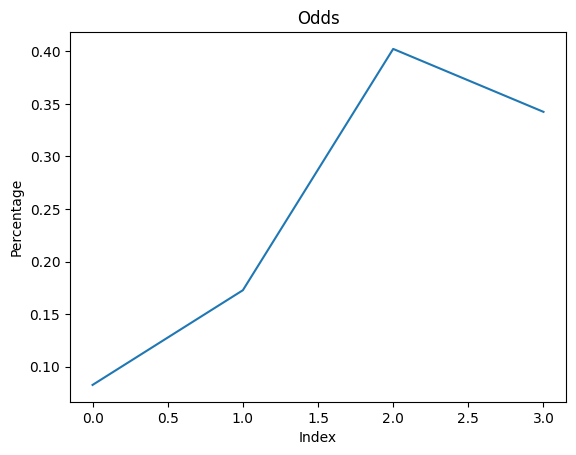

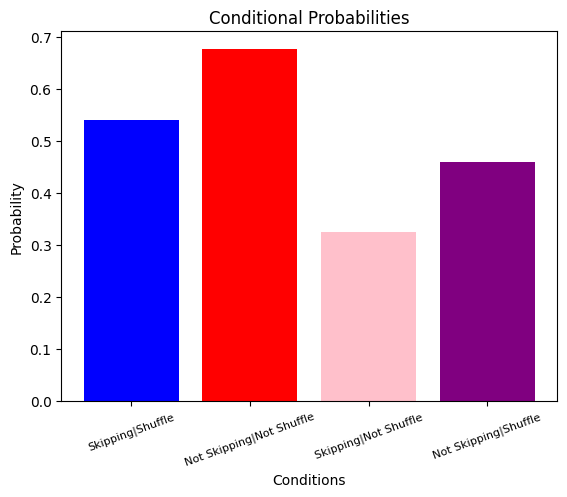

In [12]:
odds=[0,0,0,0]
odds[0]=0
odds[1]=0
odds[2]=0
odds[3]=0

onShuffle_Skip = 0
shuffle = 0
notShuffle_notSkip = 0
notShuffle = 0
notShuffle_Skip = 0
onShuffle_notSkip = 0

for x in range(len(arrShuffle)):
    if(arrShuffle[x]==arrShuffle[0] and arrReason_End[x]==0): #if listener was not on shuffle when playing track and they did not finish the song
        odds[0]+=1
        notShuffle_Skip += 1
    elif(arrShuffle[x]==arrShuffle[0] and arrReason_End[x]==1): #if the listener was not on shuffle when playing track and they did finish the song
        odds[1]+=1
        notShuffle_notSkip += 1
    elif(arrShuffle[x]!=arrShuffle[0] and arrReason_End[x]==0): #if the listener was on shuffle while playing the track and they did not finish the song
        odds[2]+=1
        onShuffle_Skip += 1
    else: #if the listener was on shuffle while playing the track and they did finish the song
        odds[3]+=1 
        onShuffle_notSkip += 1


        
odds[0]=odds[0]/len(arrShuffle) #prob of skipping song if listener is not on shuffle/ all shuffle
odds[1]=odds[1]/len(arrShuffle) #prob of finishing song if listener is not on shuffle/ all shuffle
odds[2]=odds[2]/len(arrShuffle) #prob of skipping song if listener is on shuffle/ all shuffle
odds[3]=odds[3]/len(arrShuffle) #prob of finishing song if listener is on shuffle/ all shuffle

plt.plot(range(len(odds)),odds)
plt.xlabel("Index")
plt.ylabel("Percentage")
plt.title("Odds")

plt.show()


for i in range(len(arrShuffle)):
  if arrShuffle[i] != arrShuffle[0]:
    shuffle += 1
  else:
    notShuffle += 1

# P(Skipping a song | We are on shuffle)
p1 = onShuffle_Skip / shuffle

# P(Not skipping | We are not on shuffle)
p2 = notShuffle_notSkip / notShuffle

# P(Skipping a song | We are not on shuffle)
p3 = notShuffle_Skip / notShuffle

# P(Not skipping | We are on shuffle)
p4 = onShuffle_notSkip / shuffle

positions = [0, 1, 2, 3]  # positions for bars
plt.bar([x for x in positions], [p1, p2, p3, p4], color=["blue", "red", "pink", "purple"])

plt.xticks(positions, ["Skipping|Shuffle", "Not Skipping|Not Shuffle", "Skipping|Not Shuffle", "Not Skipping|Shuffle"], fontsize=8, rotation=20)
plt.xlabel("Conditions")
plt.ylabel("Probability")
plt.title("Conditional Probabilities")

plt.show()


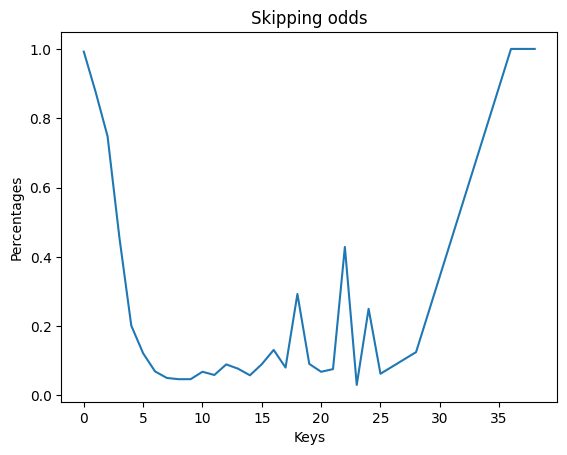

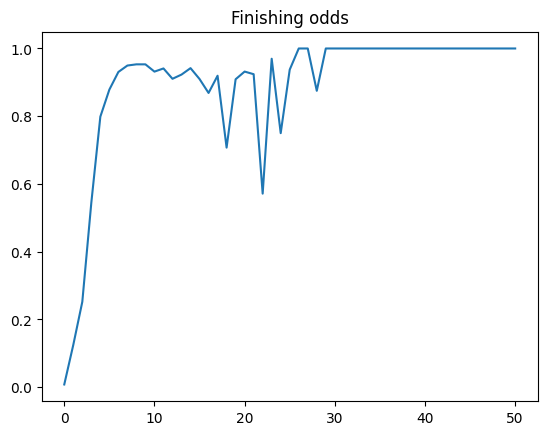

In [13]:
skippedMS={}
finishedMS={}

for x in range(len(arrMs_Played)):
    if(arrReason_End[x]==1):
        if(arrMs_Played[x]//31222.5 not in finishedMS):
            finishedMS.update({arrMs_Played[x]//31222.5:1})
        else:
            finishedMS[arrMs_Played[x]//31222.5]+=1
    else:
        if(arrMs_Played[x]//31222.5 not in skippedMS):
            skippedMS.update({arrMs_Played[x]//31222.5:1})
        else:
            skippedMS[arrMs_Played[x]//31222.5]+=1

arr1=list(skippedMS.keys())
arr1=sorted(arr1)
arr2=list(finishedMS.keys())
arr2=sorted(arr2)
arr3={}
arr4={}

for x in arr1:
    if x in arr2:
        arr3.update({x:skippedMS[x]/(skippedMS[x]+finishedMS[x])})
    else:
        arr3.update({x:1})

for x in arr2:
    if x in arr1:
        arr4.update({x:finishedMS[x]/(skippedMS[x]+finishedMS[x])})
    else:
        arr4.update({x:1})



plt.plot(list(arr3.keys()),list(arr3.values()))
plt.xlabel("Keys")
plt.ylabel("Percentages")
plt.title("Skipping odds")

plt.show()

plt.plot(list(arr4.keys()),list(arr4.values()))
plt.title("Finishing odds")
plt.show()

## Model Training - Predicting Skipped

In [4]:
#training model
data = pd.read_csv("spotify_history.csv")
data = data.drop(columns=['ts'], axis=1)
data = data.dropna()

data.to_csv("data.csv", index=False)

#converting to 0's and 1's
data['reason_end'] = (data["reason_end"] == "trackdone").astype(int)

X_train, X_test, Y_train, Y_test = train_test_split(
    data.drop(['reason_end'], axis=1),
    data['reason_end'],
    test_size=1/4.0,
    random_state=42
)

def calc_weights(set):
    counts = Counter(set)
    samples = len(set)

    weight = {item: samples / (c * len(counts)) for item, c in counts.items()}
    return weight

weights = calc_weights(Y_train)

categorical = X_train.select_dtypes(include=['object']).columns
numerical = X_train.select_dtypes(include=['number']).columns

print(categorical)
print(numerical)

cat = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

num = Pipeline([
    ('simple', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

col_trans = ColumnTransformer([
    ('numerical', num, numerical),
    ('categorical', cat, categorical),
])

model = Pipeline(steps=[
    ('col', col_trans),
    ('svm', LinearSVC(
        max_iter=1000,
        penalty="l2",
        class_weight=weights,
        C=0.1,
    ))
])

X_train.to_csv("x_train.csv", index=False)
Y_train.to_csv("y_train.csv", index=False)

model.fit(X_train, Y_train)

Index(['spotify_track_uri', 'platform', 'track_name', 'artist_name',
       'album_name', 'reason_start'],
      dtype='object')
Index(['ms_played'], dtype='object')


Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simple',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ms_played'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['spotify_track_uri', 'platform', 'track_name', 'artist_name',
       'album_name', 'reason_start'],
      dtype='object'))])),
                ('svm',
                 Li

## Accuracy on Skipping

Accuracy on training set =  0.9633629138600805
Accuracy on testing set =  0.9556024804875441
              precision    recall  f1-score   support

           0       0.98      0.93      0.95     18038
           1       0.93      0.98      0.96     19374

    accuracy                           0.96     37412
   macro avg       0.96      0.95      0.96     37412
weighted avg       0.96      0.96      0.96     37412



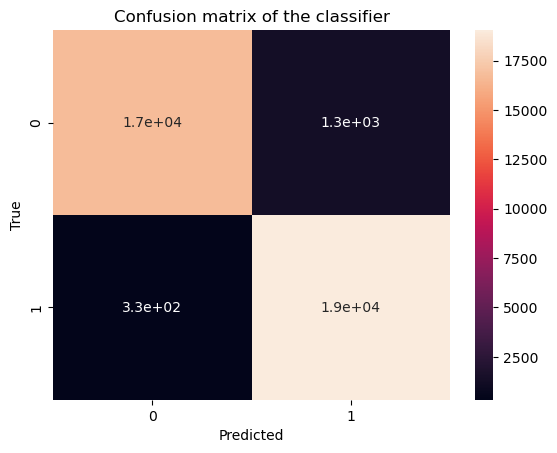

In [5]:
Y_train_pred = model.predict(X_train)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = model.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))

# Plot a confusion matrix -- commented out because it would take a while to run sometimes
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model Training - Seconds Played

In [6]:
def get_seconds_range(secs):
    secs_played = float(secs)/1000
    if secs_played <= 10:
        return "0-10"
    elif secs_played <= 20 and secs_played > 10:
        return "11-20"
    elif secs_played <= 30 and secs_played > 20:
        return "21-30"
    else:
        return "30-end"



#training model
dataTwo = pd.read_csv("spotify_history.csv")
dataTwo = dataTwo.drop(columns=['ts'], axis=1)
dataTwo = dataTwo.dropna()

#extracting feature
dataTwo["seconds_played_range"] = dataTwo["ms_played"].apply(get_seconds_range)
dataTwo = dataTwo.drop(columns=['ms_played'], axis=1)



X_train, X_test, Y_train, Y_test = train_test_split(
    dataTwo.drop(['seconds_played_range'], axis=1),
    dataTwo['seconds_played_range'],
    test_size=1/4.0,
    random_state=42
)

def calc_weights(set):
    counts = Counter(set)
    samples = len(set)

    weight = {item: samples / (c * len(counts)) for item, c in counts.items()}
    return weight

weights = calc_weights(Y_train)

categorical = X_train.select_dtypes(include=['object']).columns
numerical = X_train.select_dtypes(include=['number']).columns

print(categorical)
print(numerical)

cat = Pipeline([
    ('one_hot', OneHotEncoder(handle_unknown='ignore')),
])

num = Pipeline([
    ('simple', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

col_trans = ColumnTransformer([
    ('numerical', num, numerical),
    ('categorical', cat, categorical),
])

modelTwo = Pipeline(steps=[
    ('col', col_trans),
    ('svm', LinearSVC(
        max_iter=1000,
        penalty="l2",
        class_weight=weights,
        C=0.1,
    ))
])

# X_train.to_csv("x_train.csv", index=False)
Y_train.to_csv("y2_train.csv", index=False)

modelTwo.fit(X_train, Y_train)

Index(['spotify_track_uri', 'platform', 'track_name', 'artist_name',
       'album_name', 'reason_start', 'reason_end'],
      dtype='object')
Index([], dtype='object')


Pipeline(steps=[('col',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('simple',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index([], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['spotify_track_uri', 'platform', 'track_name', 'artist_name',
       'album_name', 'reason_start', 'reason_end'],
      dtype='object'))])),
                ('svm',
                

## Accuracy on Range of Seconds Played

Accuracy on training set =  0.8815264264585339
Accuracy on testing set =  0.8502619480380627
              precision    recall  f1-score   support

        0-10       0.83      0.88      0.86     12219
       11-20       0.14      0.23      0.17      1022
       21-30       0.08      0.20      0.12       632
      30-end       0.97      0.88      0.92     23539

    accuracy                           0.85     37412
   macro avg       0.51      0.55      0.52     37412
weighted avg       0.89      0.85      0.87     37412



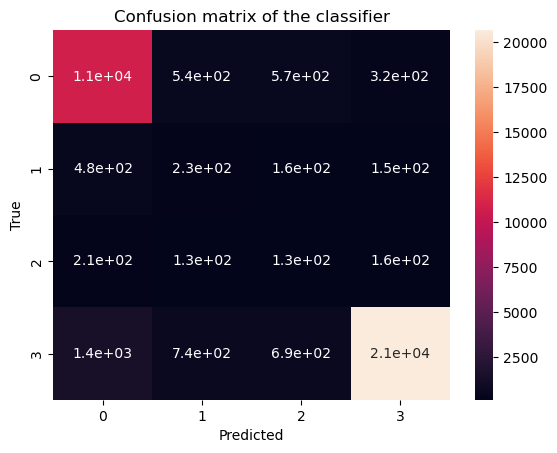

In [7]:
Y_train_pred = modelTwo.predict(X_train)
print("Accuracy on training set = ", accuracy_score(Y_train, Y_train_pred))
Y_test_pred = modelTwo.predict(X_test)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_pred))
print(classification_report(Y_test, Y_test_pred))

# Plot a confusion matrix -- commented out because it would take a while to run sometimes
cm = confusion_matrix(Y_test, Y_test_pred)
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()